In [1]:
library(tidyverse)
library(repr)
library(dplyr)
library(tidymodels)
library(gridExtra)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
tennis_data <- read_csv("https://raw.githubusercontent.com/keelbeier/dsci100-group69/main/atp2017-2019.csv")
tennis_data

New names:
• `` -> `...1`
Rows: 6866 Columns: 50
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (16): tourney_id, tourney_name, surface, tourney_level, winner_seed, win...
dbl (34): ...1, draw_size, tourney_date, match_num, winner_id, winner_ht, wi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,⋯,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2019-M020,Brisbane,Hard,32,A,20181231,300,105453,2,⋯,54,34,20,14,10,15,9,3590,16,1977
1,2019-M020,Brisbane,Hard,32,A,20181231,299,106421,4,⋯,52,36,7,10,10,13,16,1977,239,200
2,2019-M020,Brisbane,Hard,32,A,20181231,298,105453,2,⋯,27,15,6,8,1,5,9,3590,40,1050
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2883,2017-M-DC-2017-WG-M-BEL-FRA-01,Davis Cup WG F: BEL vs FRA,Hard,4,D,20171124,2,104542,NA,⋯,54,30,12,12,5,11,15,2320,76,667
2884,2017-M-DC-2017-WG-M-BEL-FRA-01,Davis Cup WG F: BEL vs FRA,Hard,4,D,20171124,4,105676,NA,⋯,54,44,13,14,7,10,7,3775,15,2320
2885,2017-M-DC-2017-WG-M-BEL-FRA-01,Davis Cup WG F: BEL vs FRA,Hard,4,D,20171124,5,106298,NA,⋯,53,29,11,11,4,11,18,2235,76,667



Above: our csv file read into R

Now, we will wrangle our data into a tidy format. We will remove all columns that we do not need.

In [3]:
tennis_data <- tennis_data |>
                    select(tourney_date, 
                      winner_age, loser_age, winner_ht, minutes) |>
                    mutate(winner_age = round(winner_age)) |>
                    mutate(loser_age = round(loser_age))|>
                    # filter(minutes < 400)|>
                    # filter(tourney_date > '20191001')|>
                    # mutate(across(c(winner_ht, winner_age), scale)) |>
                    filter(winner_ht != "NA")
tennis_data

tourney_date,winner_age,loser_age,winner_ht,minutes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20181231,29,23,178,124
20181231,29,32,178,66
20181231,34,20,188,106
⋮,⋮,⋮,⋮,⋮
20171124,33,34,188,106
20171124,27,33,163,164
20171124,24,34,185,94


Warning message:
“Removed 73 rows containing missing values (geom_point).”


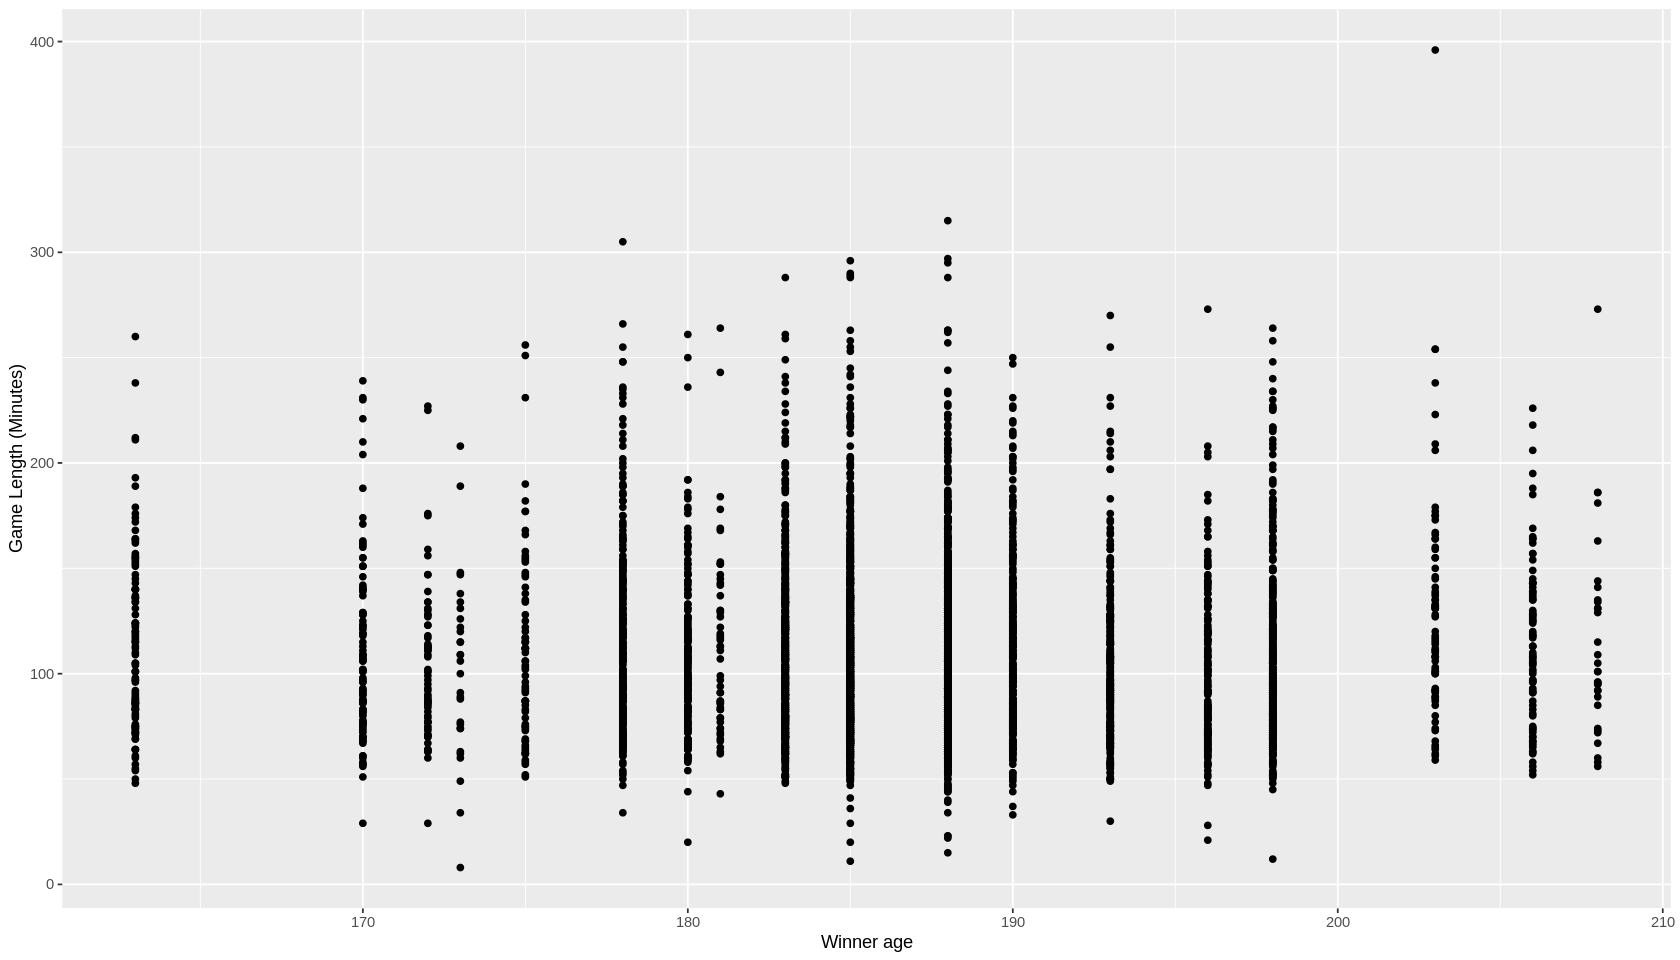

In [6]:
options(repr.plot.width=14, repr.plot.height=8)
scatter_plot <- tennis_data |> 
    ggplot(aes(x = winner_ht, y = minutes)) +
    geom_point() +
    labs(x = "Winner age",
        y = "Game Length (Minutes)")
scatter_plot

In [7]:
data_split <- initial_split(tennis_data, prop = 0.6, strata = minutes)
data_train <- training(data_split)
data_test <- testing(data_split)

In [8]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune())|>
    set_engine("kknn")|>
    set_mode("regression")

tennis_vfold <- vfold_cv(data_train, v = 5, strata = minutes)

recipe <- recipe(minutes ~ winner_ht + winner_age, data = data_train)|>
    step_scale(all_predictors())|>
    step_center(all_predictors())

data_fit <- workflow()|>
    add_recipe(recipe)|>
    add_model(knn_spec)
data_fit

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [9]:
# gridvals <- tibble(neighbors = as.integer(seq(from = 1, to = 75)))

# tennis_results <- data_fit |>
#     tune_grid(resamples = tennis_vfold, grid = gridvals) |>
#     collect_metrics() |>
#     filter(.metric == "rmse")|>
#     filter(mean == min(mean))
# tennis_results

In [10]:
set.seed(2000)

lm_spec <- linear_reg()|>
    set_engine("lm")|>
    set_mode("regression")

lm_recipe <- recipe(minutes ~ winner_ht + winner_age, data = data_train)

lm_fit <- workflow()|>
    add_recipe(lm_recipe)|>
    add_model(lm_spec) |>
    fit(data = data_train)
lm_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)    winner_ht   winner_age  
  103.61524      0.01011      0.18342  


In [11]:
lm_test_result <- lm_fit |>
    predict(data_test) |>
    bind_cols(data_test) |>
    metrics(truth = minutes, estimate = .pred)
lm_test_result

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,40.947066660
rsq,standard,0.002626974
mae,standard,31.894414513
